In [4]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load the dataset
df = pd.read_csv("/users/utkarshtyagi/documents/vsc/dataset/GP3_Data.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Create the 'Post' variable (1 = after March 1, 0 = before)
df['Post'] = (df['Date'] >= '2023-03-01').astype(int)

# Create the log(Quantity) variable for elasticity
df['log_Quantity'] = np.log(df['Quantity Ordered'])

In [5]:
# Dataset 1: For Food Price Analysis (Regions 1, 2, 3)
df_food_analysis = df[df['Region'].isin([1, 2, 3])].copy()

# Dataset 2: For Delivery Price Analysis (Regions 1, 2, 4)
df_delivery_analysis = df[df['Region'].isin([1, 2, 4])].copy()

In [6]:
# --- Analysis 1: Food Price in Region 3 ---

# Create the 'Treat' variable (1 = Region 3, 0 = Regions 1 or 2)
df_food_analysis['Treat'] = (df_food_analysis['Region'] == 3).astype(int)

# Run the DiD model
model_food = smf.ols('log_Quantity ~ Treat * Post', data=df_food_analysis).fit()

print("--- Food Price DiD Results (Region 3 vs 1 & 2) ---")
print(model_food.summary())

--- Food Price DiD Results (Region 3 vs 1 & 2) ---
                            OLS Regression Results                            
Dep. Variable:           log_Quantity   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     106.6
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           2.98e-49
Time:                        22:29:40   Log-Likelihood:                -64.012
No. Observations:                 360   AIC:                             136.0
Df Residuals:                     356   BIC:                             151.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
I

In [7]:
# --- Analysis 2: Delivery Price in Region 4 ---

# Create the 'Treat' variable (1 = Region 4, 0 = Regions 1 or 2)
df_delivery_analysis['Treat'] = (df_delivery_analysis['Region'] == 4).astype(int)

# Run the DiD model
model_delivery = smf.ols('log_Quantity ~ Treat * Post', data=df_delivery_analysis).fit()

print("\n--- Delivery Price DiD Results (Region 4 vs 1 & 2) ---")
print(model_delivery.summary())


--- Delivery Price DiD Results (Region 4 vs 1 & 2) ---
                            OLS Regression Results                            
Dep. Variable:           log_Quantity   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     158.4
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           3.25e-65
Time:                        22:30:07   Log-Likelihood:                -212.22
No. Observations:                 360   AIC:                             432.4
Df Residuals:                     356   BIC:                             448.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

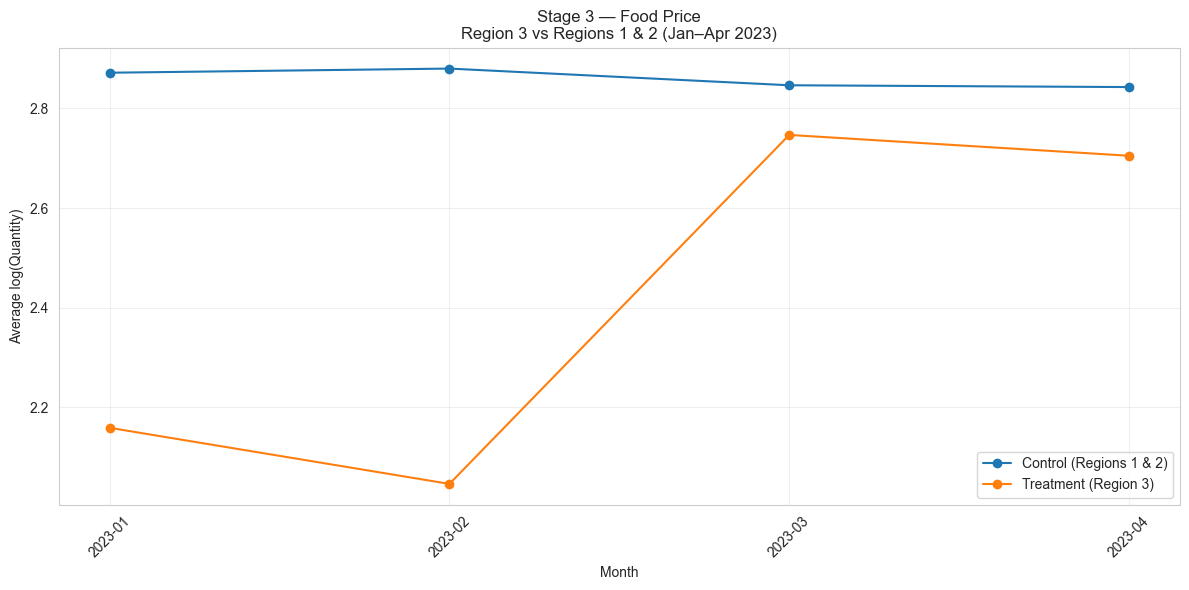

In [13]:
# ============================
#     STAGE 3 — REGION 3
#  Food Price Parallel Trends
# ============================

# Create log quantity variable
df['log_Quantity'] = np.log(df['Quantity Ordered'])

# Create Month column (Jan–Apr)
df['Month'] = df['Date'].dt.to_period('M')

# Filter regions 1, 2, 3
df_food = df[df['Region'].isin([1, 2, 3])].copy()

# Create Treat variable for Region 3
df_food['Treat'] = (df_food['Region'] == 3).astype(int)

# Monthly averages of log quantity
food_monthly = (
    df_food.groupby(['Month', 'Treat'])['log_Quantity']
    .mean()
    .reset_index()
)

# Convert month to string for plotting
food_monthly['Month'] = food_monthly['Month'].astype(str)

# ===== Plot =====
plt.figure(figsize=(12, 6))

# Control = Regions 1 & 2
control = food_monthly[food_monthly['Treat'] == 0]
plt.plot(control['Month'], control['log_Quantity'], marker='o',
         label='Control (Regions 1 & 2)')

# Treatment = Region 3
treat = food_monthly[food_monthly['Treat'] == 1]
plt.plot(treat['Month'], treat['log_Quantity'], marker='o',
         label='Treatment (Region 3)')

plt.title("Stage 3 — Food Price\nRegion 3 vs Regions 1 & 2 (Jan–Apr 2023)")
plt.xlabel("Month")
plt.ylabel("Average log(Quantity)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


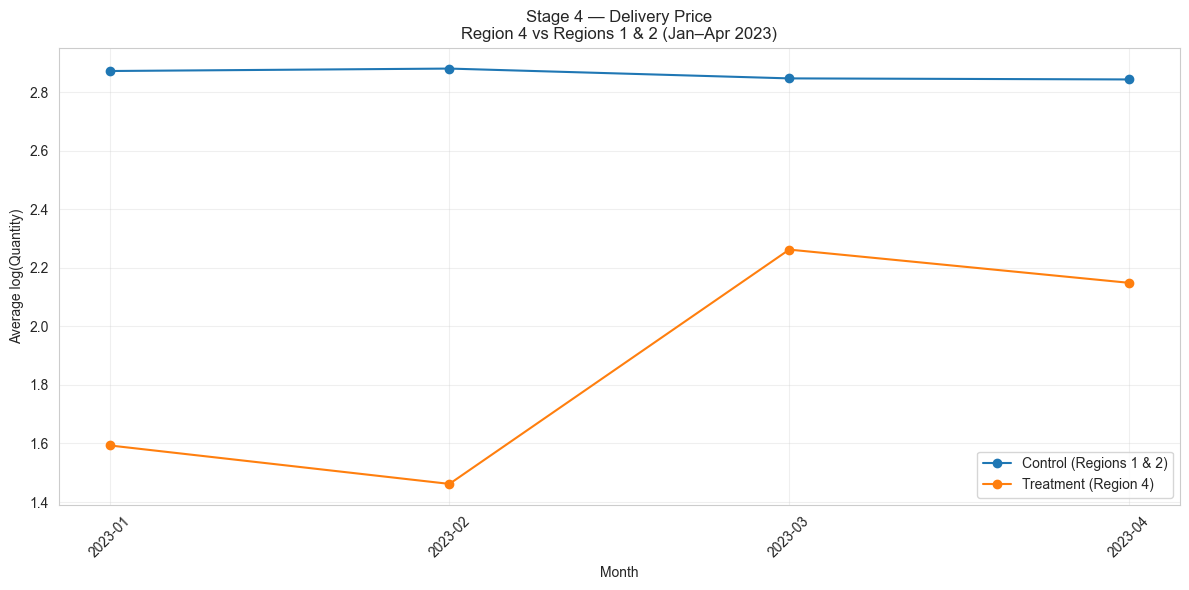

In [14]:
# ============================
#     STAGE 4 — REGION 4
# Delivery Price Parallel Trends
# ============================

# Filter regions 1, 2, 4
df_del = df[df['Region'].isin([1, 2, 4])].copy()

# Create Treat variable for Region 4
df_del['Treat'] = (df_del['Region'] == 4).astype(int)

# Monthly averages of log quantity
del_monthly = (
    df_del.groupby(['Month', 'Treat'])['log_Quantity']
    .mean()
    .reset_index()
)

del_monthly['Month'] = del_monthly['Month'].astype(str)

# ===== Plot =====
plt.figure(figsize=(12, 6))

# Control = Regions 1 & 2
control_del = del_monthly[del_monthly['Treat'] == 0]
plt.plot(control_del['Month'], control_del['log_Quantity'], marker='o',
         label='Control (Regions 1 & 2)')

# Treatment = Region 4
treat_del = del_monthly[del_monthly['Treat'] == 1]
plt.plot(treat_del['Month'], treat_del['log_Quantity'], marker='o',
         label='Treatment (Region 4)')

plt.title("Stage 4 — Delivery Price\nRegion 4 vs Regions 1 & 2 (Jan–Apr 2023)")
plt.xlabel("Month")
plt.ylabel("Average log(Quantity)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [15]:
# ========= PARALLEL TRENDS TEST (FORMAL REGRESSION) =========

# Pre-period only
df_pre = df_food_analysis[df_food_analysis['Post'] == 0].copy()

# Time trend in days (numeric)
df_pre['time_trend'] = (df_pre['Date'] - df_pre['Date'].min()).dt.days

# Regression: interaction of Treat × time_trend
parallel_test = smf.ols("log_Quantity ~ Treat * time_trend", data=df_pre).fit()

print("\n=== FORMAL PARALLEL TRENDS TEST ===")
print(parallel_test.summary())



=== FORMAL PARALLEL TRENDS TEST ===
                            OLS Regression Results                            
Dep. Variable:           log_Quantity   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     56.75
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           1.36e-25
Time:                        22:55:07   Log-Likelihood:                -75.077
No. Observations:                 177   AIC:                             158.2
Df Residuals:                     173   BIC:                             170.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Int

In [17]:
# ===========================
#   PARALLEL TRENDS (R4)
# ===========================

df_pre4 = df_delivery_analysis[df_delivery_analysis['Post'] == 0].copy()

df_pre4['time_trend'] = (df_pre4['Date'] - df_pre4['Date'].min()).dt.days

parallel_test_r4 = smf.ols("log_Quantity ~ Treat * time_trend", data=df_pre4).fit()

print("\n=== REGION 4 FORMAL PARALLEL TRENDS TEST ===")
print(parallel_test_r4.summary())



=== REGION 4 FORMAL PARALLEL TRENDS TEST ===
                            OLS Regression Results                            
Dep. Variable:           log_Quantity   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     76.35
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           1.67e-31
Time:                        22:56:59   Log-Likelihood:                -145.62
No. Observations:                 177   AIC:                             299.2
Df Residuals:                     173   BIC:                             312.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [19]:
# ========= PLACEBO TEST =========

df_placebo = df_food_analysis.copy()

# Fake treatment date: Feb 1
df_placebo['PlaceboPost'] = (df_placebo['Date'] >= '2023-02-01').astype(int)

placebo_model = smf.ols("log_Quantity ~ Treat * PlaceboPost", data=df_placebo).fit()

print("\n=== PLACEBO TEST RESULTS (FAKE POLICY IN FEB) ===")
print(placebo_model.summary())



=== PLACEBO TEST RESULTS (FAKE POLICY IN FEB) ===
                            OLS Regression Results                            
Dep. Variable:           log_Quantity   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     55.92
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           1.22e-29
Time:                        22:58:14   Log-Likelihood:                -109.88
No. Observations:                 360   AIC:                             227.8
Df Residuals:                     356   BIC:                             243.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [20]:
# ===========================
#   PLACEBO TEST (R4)
# ===========================

df_placebo4 = df_delivery_analysis.copy()

df_placebo4['PlaceboPost'] = (df_placebo4['Date'] >= '2023-02-01').astype(int)

placebo_model_r4 = smf.ols("log_Quantity ~ Treat * PlaceboPost", data=df_placebo4).fit()

print("\n=== REGION 4 PLACEBO TEST RESULTS ===")
print(placebo_model_r4.summary())



=== REGION 4 PLACEBO TEST RESULTS ===
                            OLS Regression Results                            
Dep. Variable:           log_Quantity   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     121.8
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           2.69e-54
Time:                        22:58:47   Log-Likelihood:                -237.70
No. Observations:                 360   AIC:                             483.4
Df Residuals:                     356   BIC:                             498.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [32]:
model_demand_r3 = smf.ols("log_Quantity ~ Q('Unit Price')", data=df_r3).fit()
print(model_demand_r3.summary())


                            OLS Regression Results                            
Dep. Variable:           log_Quantity   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     55.13
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           1.92e-11
Time:                        23:24:37   Log-Likelihood:                -75.512
No. Observations:                 120   AIC:                             155.0
Df Residuals:                     118   BIC:                             160.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          14.5196      1.630     

In [33]:
model_demand_r4 = smf.ols("log_Quantity ~ Q('Delivery Fees')", data=df_r4).fit()
print(model_demand_r4.summary())


                            OLS Regression Results                            
Dep. Variable:           log_Quantity   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     25.54
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           1.60e-06
Time:                        23:24:59   Log-Likelihood:                -131.78
No. Observations:                 120   AIC:                             267.6
Df Residuals:                     118   BIC:                             273.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             15.0353      2

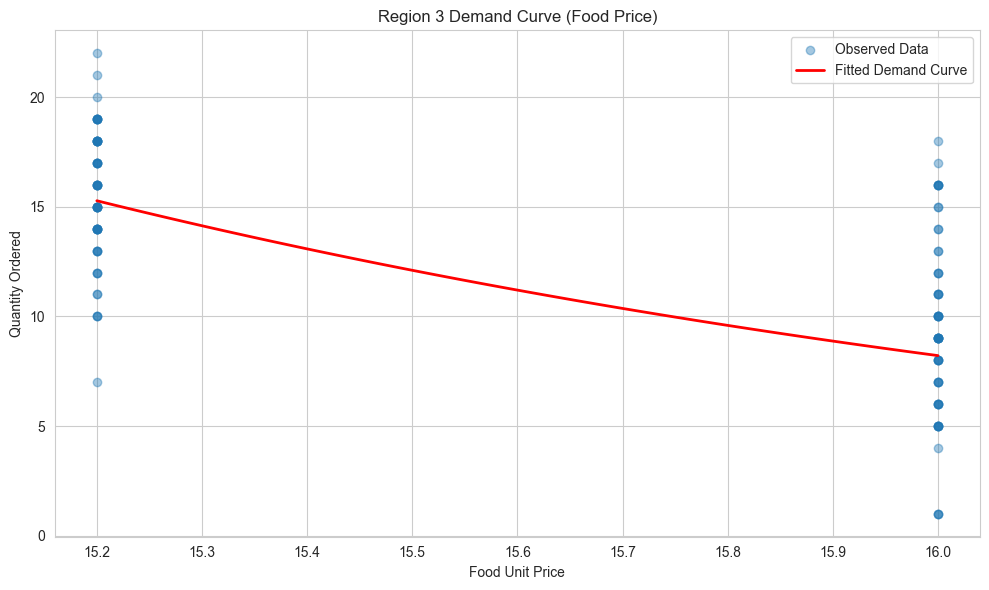

In [35]:
#   REGION 3 — FOOD PRICE DEMAND CURVE VISUALIZATION
# ======================================================

df_r3 = df[df['Region'] == 3].copy()

# Fit regression again (for prediction)
model_demand_r3 = smf.ols("log_Quantity ~ Q('Unit Price')", data=df_r3).fit()

# Generate predictions for smooth curve
price_range_r3 = np.linspace(df_r3['Unit Price'].min(), df_r3['Unit Price'].max(), 100)
pred_log_q_r3 = model_demand_r3.predict({"Unit Price": price_range_r3})
pred_q_r3 = np.exp(pred_log_q_r3)  # convert back from log

plt.figure(figsize=(10, 6))

# Scatter plot of actual data
plt.scatter(df_r3['Unit Price'], df_r3['Quantity Ordered'], alpha=0.4, label="Observed Data")

# Fitted demand curve
plt.plot(price_range_r3, pred_q_r3, color='red', linewidth=2, label="Fitted Demand Curve")

plt.title("Region 3 Demand Curve (Food Price)")
plt.xlabel("Food Unit Price")
plt.ylabel("Quantity Ordered")
plt.legend()
plt.tight_layout()
plt.show()

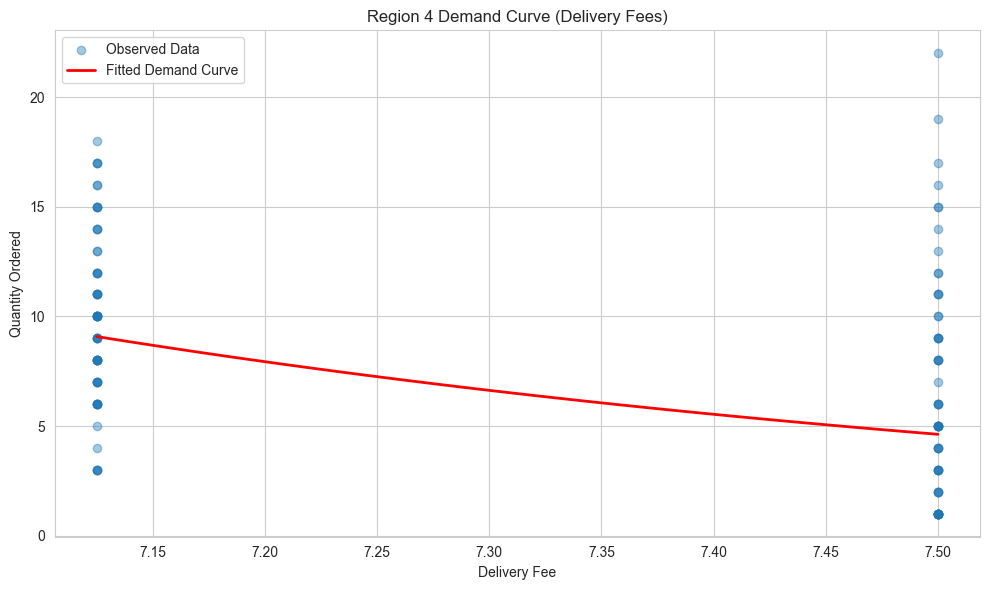

In [36]:
#   REGION 4 — DELIVERY FEE DEMAND CURVE VISUALIZATION
# ======================================================

df_r4 = df[df['Region'] == 4].copy()

# Fit regression again
model_demand_r4 = smf.ols("log_Quantity ~ Q('Delivery Fees')", data=df_r4).fit()

# Predictions for curve
fee_range_r4 = np.linspace(df_r4['Delivery Fees'].min(), df_r4['Delivery Fees'].max(), 100)
pred_log_q_r4 = model_demand_r4.predict({"Delivery Fees": fee_range_r4})
pred_q_r4 = np.exp(pred_log_q_r4)

plt.figure(figsize=(10, 6))

# Scatter plot of actual data
plt.scatter(df_r4['Delivery Fees'], df_r4['Quantity Ordered'], alpha=0.4, label="Observed Data")

# Fitted demand curve
plt.plot(fee_range_r4, pred_q_r4, color='red', linewidth=2, label="Fitted Demand Curve")

plt.title("Region 4 Demand Curve (Delivery Fees)")
plt.xlabel("Delivery Fee")
plt.ylabel("Quantity Ordered")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
df[df['Region'] == 4]['Distance'].mean()


np.float64(15.0)

Average distance (Region 3): 9.0
Marginal Cost (Region 3): $ 4.5

*** IMPORTANT: |Elasticity| < 1 → NO interior optimum.
Profit increases as price increases. The model predicts raising price further.


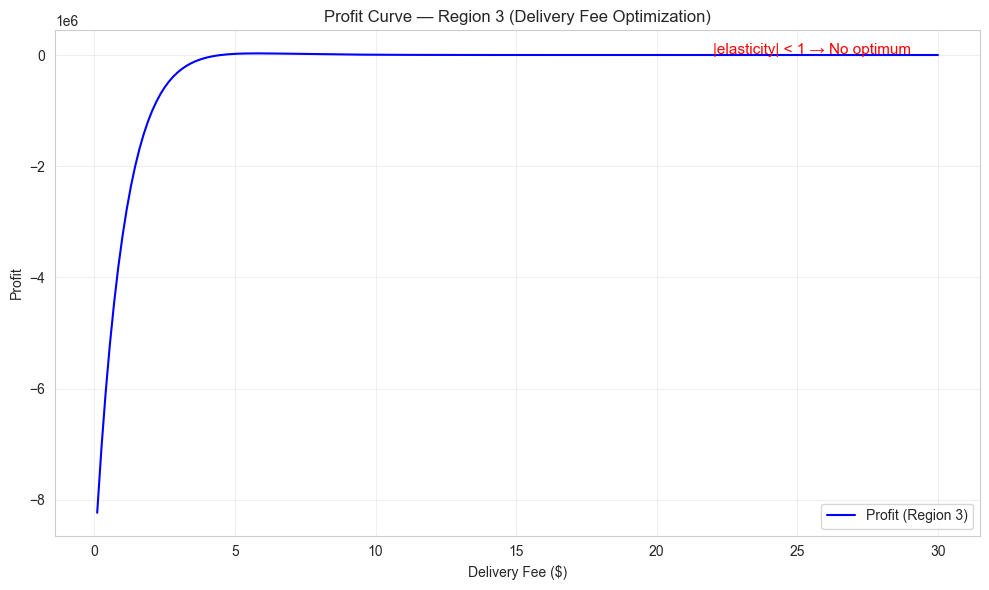

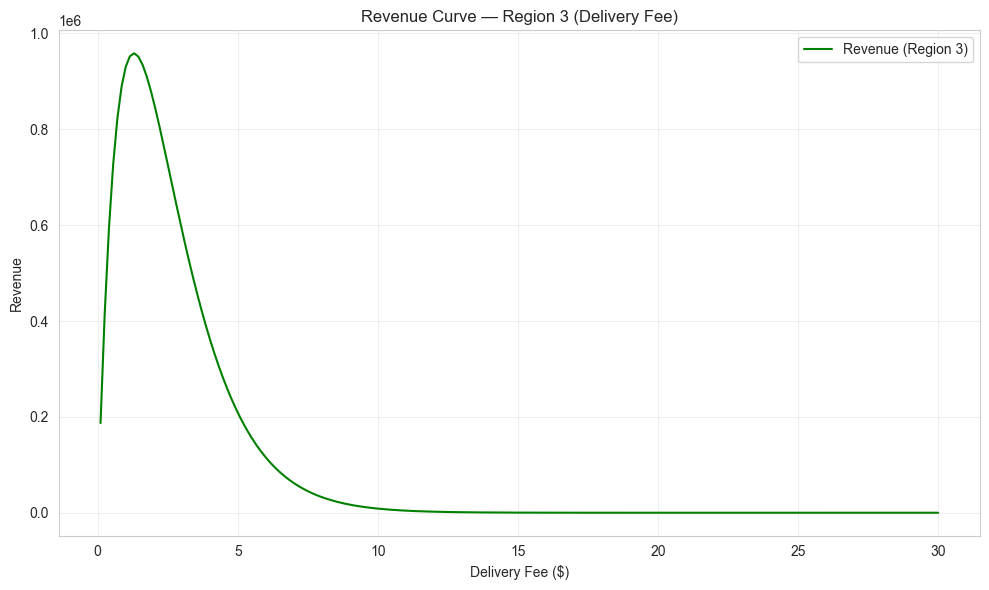

In [38]:
# 1. Compute Marginal Cost for Region 3
# ======================================================

avg_dist_r3 = df[df['Region'] == 3]['Distance'].mean()
MC_r3 = 0.5 * avg_dist_r3    # delivery cost per mile = $0.50

print("Average distance (Region 3):", avg_dist_r3)
print("Marginal Cost (Region 3): $", MC_r3)


# ======================================================
# 2. Demand parameters from Region 3 regression
# ======================================================

intercept_r3 = 14.5196      # from your regression
elasticity_r3 = -0.7759     # from your regression

# Demand: Q = exp(intercept + elasticity * P)


# ======================================================
# 3. Compute Optimal Price (profit-maximizing delivery fee)
#    Note: If |elasticity| < 1, no interior optimum exists.
# ======================================================

if abs(elasticity_r3) <= 1:
    print("\n*** IMPORTANT: |Elasticity| < 1 → NO interior optimum.")
    print("Profit increases as price increases. The model predicts raising price further.")
    P_star_r3 = None
else:
    P_star_r3 = (abs(elasticity_r3) / (abs(elasticity_r3) - 1)) * MC_r3
    print("\nOptimal Delivery Fee (Region 3): $", round(P_star_r3, 2))


# ======================================================
# 4. Compute Quantities, Revenue & Profit Curves
# ======================================================

prices = np.linspace(0.1, 30, 200)   # delivery fee range
quantities = np.exp(intercept_r3 + elasticity_r3 * prices)
revenue = prices * quantities
profit = (prices - MC_r3) * quantities


# ======================================================
# 5. Plot Profit Curve
# ======================================================

plt.figure(figsize=(10, 6))
plt.plot(prices, profit, label="Profit (Region 3)", color="blue")

if P_star_r3 is not None:
    plt.axvline(P_star_r3, color='red', linestyle='--',
                label=f"Optimal Price = ${round(P_star_r3,2)}")
else:
    plt.text(22, max(profit)*0.9,
             "|elasticity| < 1 → No optimum",
             fontsize=11, color="red")

plt.title("Profit Curve — Region 3 (Delivery Fee Optimization)")
plt.xlabel("Delivery Fee ($)")
plt.ylabel("Profit")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ======================================================
# 6. Plot Revenue Curve
# ======================================================

plt.figure(figsize=(10, 6))
plt.plot(prices, revenue, label="Revenue (Region 3)", color="green")

if P_star_r3 is not None:
    plt.axvline(P_star_r3, color='red', linestyle='--',
                label=f"Optimal Price = ${round(P_star_r3,2)}")

plt.title("Revenue Curve — Region 3 (Delivery Fee)")
plt.xlabel("Delivery Fee ($)")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ======================================================
# 7. Quantity at Optimal Price (if exists)
# ======================================================

if P_star_r3 is not None:
    Q_star_r3 = np.exp(intercept_r3 + elasticity_r3 * P_star_r3)
    print("\nPredicted quantity at optimal price:", round(Q_star_r3, 2))

Average distance (Region 4): 15.0
Marginal Cost (Region 4): $ 7.5

=== OPTIMAL DELIVERY FEE (Region 4) ===
Optimal Delivery Fee: $ 16.87


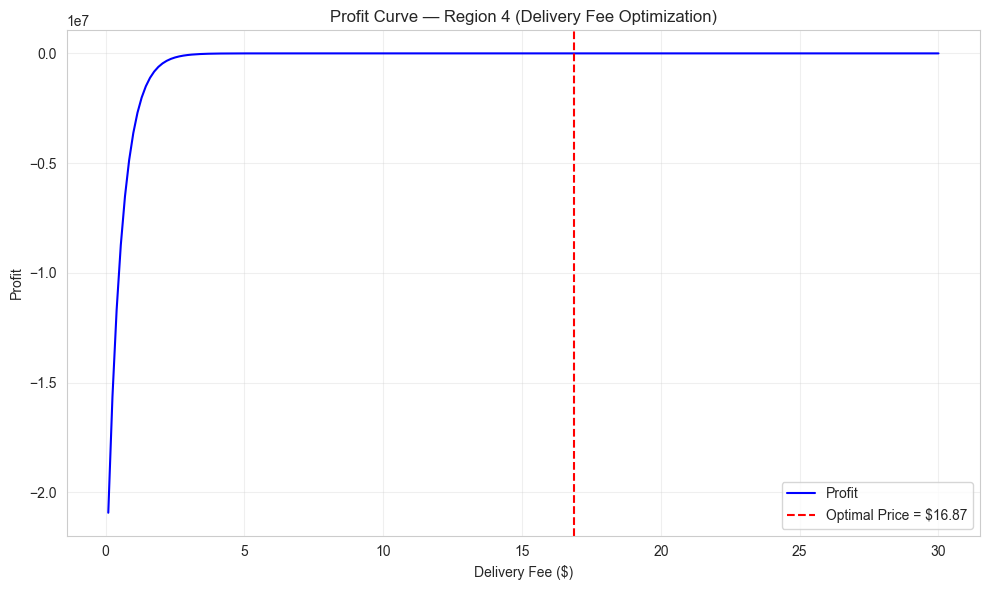

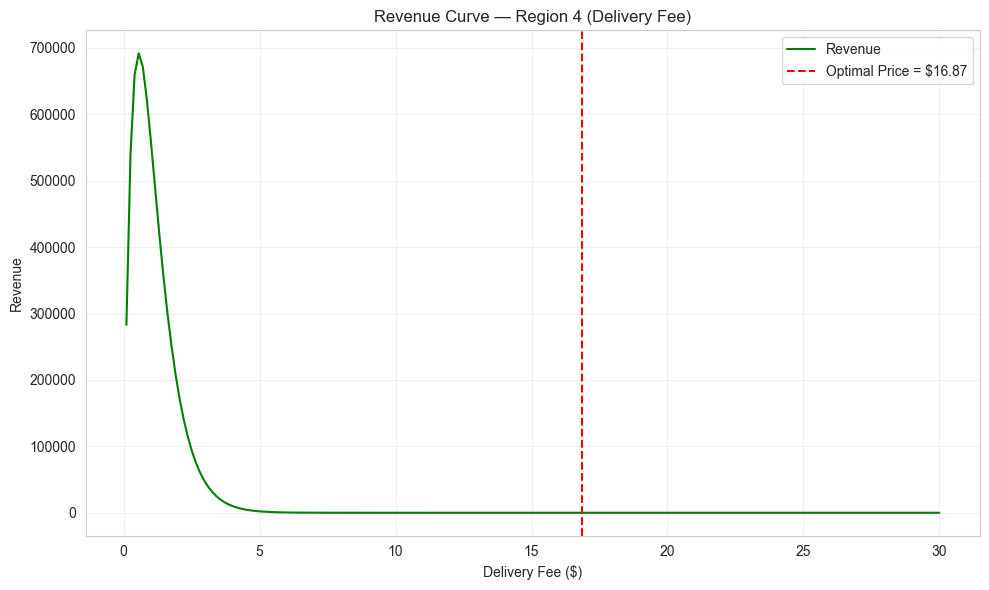


=== QUANTITY AT OPTIMAL PRICE ===
Predicted quantity at P* = 0.0


In [39]:



# 1. Compute Marginal Cost for Region 4
# ======================================================

# Average distance (you already computed)
avg_dist_r4 = 15.0  
MC_r4 = 0.5 * avg_dist_r4     # delivery cost per mile = $0.50

print("Average distance (Region 4):", avg_dist_r4)
print("Marginal Cost (Region 4): $", MC_r4)


# ======================================================
# 2. Retrieve Demand Elasticity & Intercept from Regression
# ======================================================

elasticity_r4 = -1.8006        # from your regression
intercept_r4 = 15.0353         # from your regression

# Demand curve: ln(Q) = intercept + elasticity * price
# => Q = exp(intercept + elasticity * price)


# ======================================================
# 3. Compute Optimal Price (profit-maximizing delivery fee)
# ======================================================

P_star_r4 = (abs(elasticity_r4) / (abs(elasticity_r4) - 1)) * MC_r4

print("\n=== OPTIMAL DELIVERY FEE (Region 4) ===")
print("Optimal Delivery Fee: $", round(P_star_r4, 2))


# ======================================================
# 4. Compute Profit & Revenue Curves
# ======================================================

# Price range for graphing (0 to 30 dollars)
prices = np.linspace(0.1, 30, 200)

# Demand function (predicted quantity)
quantities = np.exp(intercept_r4 + elasticity_r4 * prices)

# Revenue = P * Q
revenue = prices * quantities

# Profit = (P - MC) * Q
profit = (prices - MC_r4) * quantities


# ======================================================
# 5. Plot: Profit Curve & Optimal Price
# ======================================================

plt.figure(figsize=(10, 6))
plt.plot(prices, profit, label="Profit", color="blue")
plt.axvline(P_star_r4, color='red', linestyle='--', label=f"Optimal Price = ${round(P_star_r4,2)}")
plt.title("Profit Curve — Region 4 (Delivery Fee Optimization)")
plt.xlabel("Delivery Fee ($)")
plt.ylabel("Profit")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ======================================================
# 6. Plot: Revenue Curve
# ======================================================

plt.figure(figsize=(10, 6))
plt.plot(prices, revenue, label="Revenue", color="green")
plt.axvline(P_star_r4, color='red', linestyle='--', label=f"Optimal Price = ${round(P_star_r4,2)}")
plt.title("Revenue Curve — Region 4 (Delivery Fee)")
plt.xlabel("Delivery Fee ($)")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ======================================================
# 7. Print Quantity at Optimal Price
# ======================================================

Q_star_r4 = np.exp(intercept_r4 + elasticity_r4 * P_star_r4)

print("\n=== QUANTITY AT OPTIMAL PRICE ===")
print("Predicted quantity at P* =", round(Q_star_r4, 2))
